In [1]:
import sys
from pathlib import Path

project_root = Path.cwd().parent.parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

print(f"Project root added to path: {project_root}")
print(f"Current working directory: {Path.cwd()}")

Project root added to path: /home/mohamed-ashraf/Desktop/projects/Arabic-Diacritization
Current working directory: /home/mohamed-ashraf/Desktop/projects/Arabic-Diacritization/models/bilstm2_bow


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import pickle
import matplotlib.pyplot as plt

from tqdm import tqdm
from utils.feature_extractors import BOWVectorizer
from models.bilstm2_bow.bilstm2_bow import BiLSTM_BOW
from utils.utils import create_data_pipeline

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [4]:
with open(project_root / "utils/letter2idx.pickle", "rb") as file:
    letter2idx = pickle.load(file)

with open(project_root / "utils/diacritic2id.pickle", "rb") as file:
    diacritic2id = pickle.load(file)

idx2letter = {value: key for key, value in letter2idx.items()}
idx2diacritic = {value: key for key, value in diacritic2id.items()}

print(f"Vocabulary size: {len(letter2idx)}")
print(f"Number of diacritic classes: {len(diacritic2id)}")

Vocabulary size: 38
Number of diacritic classes: 16


In [5]:
def pad_collate_fn(batch):
    x_batch, y_batch, mask_batch = zip(*batch)
    lengths_x = [len(x) for x in x_batch]
    x_padded = torch.nn.utils.rnn.pad_sequence(x_batch, batch_first=True, padding_value=letter2idx['<PAD>'])
    y_padded = torch.nn.utils.rnn.pad_sequence(y_batch, batch_first=True, padding_value=diacritic2id['<PAD>'])
    mask_spadded = torch.nn.utils.rnn.pad_sequence(mask_batch, batch_first=True, padding_value=0)
    return x_padded, y_padded, mask_spadded, torch.tensor(lengths_x, dtype=torch.long)

In [6]:
bow_vectorizer = BOWVectorizer(binary=False)

train_dataset, train_loader, bow_vectorizer = create_data_pipeline(
    corpus_path=str(project_root / 'data/train.txt'),
    letter2idx=letter2idx,
    diacritic2idx=diacritic2id,
    bow_vectorizer=bow_vectorizer,
    collate_fn=pad_collate_fn,
    train=True,
    batch_size=32,
    window_size=3
)

val_dataset, val_loader, _ = create_data_pipeline(
    corpus_path=str(project_root / 'data/val.txt'),
    letter2idx=letter2idx,
    diacritic2idx=diacritic2id,
    bow_vectorizer=bow_vectorizer,
    collate_fn=pad_collate_fn,
    train=False,
    batch_size=32,
    window_size=3
)

print(f"\nBOW vocabulary size: {len(bow_vectorizer.vectorizer.vocabulary_)}")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")


BOW vocabulary size: 36
Training samples: 184519
Validation samples: 8973


In [7]:
bow_vocab_size = len(bow_vectorizer.vectorizer.vocabulary_)
num_classes = len(diacritic2id)

model = BiLSTM_BOW(
    bow_vocab_size=bow_vocab_size,
    num_classes=num_classes,
    hidden_size=256,
    num_layers=2,
    dropout=0.3
).to(device)

print("Model architecture:")
print(model)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Model architecture:
BiLSTM_BOW(
  (bilstm): LSTM(36, 256, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (lstm_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=512, out_features=16, bias=True)
)

Total parameters: 2,188,304
Trainable parameters: 2,188,304


In [8]:
def train_model(model, train_loader, val_loader, epochs=10, learning_rate=0.001):
    criterion = nn.CrossEntropyLoss(ignore_index=diacritic2id['<PAD>'])
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5)
    
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    
    best_val_loss = float('inf')
    best_model_path = 'best_bilstm_model.pth'

    for epoch in range(epochs):
        model.train()

        total_train_loss = 0
        total_train_correct = 0
        total_train_tokens = 0

        with tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs} [Train]') as pbar:
            for batch_X, batch_y, _, lengths in pbar:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                
                optimizer.zero_grad()

                outputs = model(batch_X, lengths)

                B, T, C = outputs.shape
                loss = criterion(outputs.view(B*T, C), batch_y.view(B*T))

                preds = outputs.argmax(dim=-1)
                mask = (batch_y != diacritic2id['<PAD>'])

                correct = (preds[mask] == batch_y[mask]).sum().item()
                total = mask.sum().item()

                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()

                total_train_loss += loss.item()
                total_train_correct += correct
                total_train_tokens += total

                acc = correct / total if total > 0 else 0.0

                pbar.set_postfix({
                    'Loss': f'{loss.item():.4f}',
                    'Acc': f'{acc:.4f}'
                })

        avg_train_loss = total_train_loss / len(train_loader)
        avg_train_acc = total_train_correct / total_train_tokens

        model.eval()
        total_val_loss = 0
        total_val_correct = 0
        total_val_tokens = 0

        with torch.no_grad():
            with tqdm(val_loader, desc=f'Epoch {epoch+1}/{epochs} [Val]') as pbar:
                for batch_X, batch_y, _, lengths in pbar:
                    batch_X, batch_y = batch_X.to(device), batch_y.to(device)

                    outputs = model(batch_X, lengths)
                    B, T, C = outputs.shape

                    loss = criterion(outputs.view(B*T, C), batch_y.view(B*T))

                    preds = outputs.argmax(dim=-1)
                    mask = (batch_y != diacritic2id['<PAD>'])

                    correct = (preds[mask] == batch_y[mask]).sum().item()
                    total = mask.sum().item()

                    total_val_loss += loss.item()
                    total_val_correct += correct
                    total_val_tokens += total

                    acc = correct / total if total > 0 else 0.0

                    pbar.set_postfix({
                        'Loss': f'{loss.item():.4f}',
                        'Acc': f'{acc:.4f}'
                    })

        avg_val_loss = total_val_loss / len(val_loader)
        avg_val_acc = total_val_correct / total_val_tokens

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': best_val_loss,
                'val_accuracy': avg_val_acc,
                'train_loss': avg_train_loss,
                'train_accuracy': avg_train_acc
            }, best_model_path)
            print(f"  ↳ Best model saved! (val_loss: {best_val_loss:.4f})")

        scheduler.step(avg_val_loss)

        print(f'Epoch {epoch+1}/{epochs}:')
        print(f'  Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc:.4f}')
        print(f'  Val Loss: {avg_val_loss:.4f}, Val Acc: {avg_val_acc:.4f}')
        print(f'  LR: {optimizer.param_groups[0]["lr"]:.6f}')

        train_losses.append(avg_train_loss)
        train_accuracies.append(avg_train_acc)
        val_losses.append(avg_val_loss)
        val_accuracies.append(avg_val_acc)

    return {
        'train_loss': train_losses,
        'train_accuracy': train_accuracies,
        'val_loss': val_losses,
        'val_accuracy': val_accuracies
    }

In [9]:
print("\nStarting training with BOW features...")
history = train_model(model, train_loader, val_loader, epochs=10, learning_rate=0.001)


Starting training with BOW features...


Epoch 1/10 [Val]: 100%|██████████| 281/281 [00:17<00:00, 16.34it/s, Loss=0.1896, Acc=0.9444]


  ↳ Best model saved! (val_loss: 0.1613)
Epoch 1/10:
  Train Loss: 0.3423, Train Acc: 0.8813
  Val Loss: 0.1613, Val Acc: 0.9462
  LR: 0.001000


Epoch 2/10 [Val]: 100%|██████████| 281/281 [00:17<00:00, 16.18it/s, Loss=0.1366, Acc=0.9541]


  ↳ Best model saved! (val_loss: 0.1231)
Epoch 2/10:
  Train Loss: 0.1585, Train Acc: 0.9475
  Val Loss: 0.1231, Val Acc: 0.9599
  LR: 0.001000


Epoch 3/10 [Val]: 100%|██████████| 281/281 [00:18<00:00, 14.91it/s, Loss=0.1149, Acc=0.9614]


  ↳ Best model saved! (val_loss: 0.1079)
Epoch 3/10:
  Train Loss: 0.1295, Train Acc: 0.9573
  Val Loss: 0.1079, Val Acc: 0.9650
  LR: 0.001000


Epoch 4/10 [Val]: 100%|██████████| 281/281 [00:18<00:00, 15.41it/s, Loss=0.1135, Acc=0.9638]


  ↳ Best model saved! (val_loss: 0.0997)
Epoch 4/10:
  Train Loss: 0.1146, Train Acc: 0.9623
  Val Loss: 0.0997, Val Acc: 0.9676
  LR: 0.001000


Epoch 5/10 [Val]: 100%|██████████| 281/281 [00:18<00:00, 15.24it/s, Loss=0.1072, Acc=0.9662]


  ↳ Best model saved! (val_loss: 0.0952)
Epoch 5/10:
  Train Loss: 0.1050, Train Acc: 0.9654
  Val Loss: 0.0952, Val Acc: 0.9693
  LR: 0.001000


Epoch 6/10 [Val]: 100%|██████████| 281/281 [00:18<00:00, 14.93it/s, Loss=0.1154, Acc=0.9686]


  ↳ Best model saved! (val_loss: 0.0913)
Epoch 6/10:
  Train Loss: 0.0984, Train Acc: 0.9676
  Val Loss: 0.0913, Val Acc: 0.9706
  LR: 0.001000


Epoch 7/10 [Val]: 100%|██████████| 281/281 [00:18<00:00, 14.92it/s, Loss=0.1525, Acc=0.9589]


  ↳ Best model saved! (val_loss: 0.0891)
Epoch 7/10:
  Train Loss: 0.0930, Train Acc: 0.9693
  Val Loss: 0.0891, Val Acc: 0.9714
  LR: 0.001000


Epoch 8/10 [Val]: 100%|██████████| 281/281 [00:18<00:00, 15.36it/s, Loss=0.0951, Acc=0.9686]


  ↳ Best model saved! (val_loss: 0.0876)
Epoch 8/10:
  Train Loss: 0.0891, Train Acc: 0.9706
  Val Loss: 0.0876, Val Acc: 0.9724
  LR: 0.001000


Epoch 9/10 [Val]: 100%|██████████| 281/281 [00:18<00:00, 15.08it/s, Loss=0.0881, Acc=0.9710]


  ↳ Best model saved! (val_loss: 0.0856)
Epoch 9/10:
  Train Loss: 0.0855, Train Acc: 0.9717
  Val Loss: 0.0856, Val Acc: 0.9728
  LR: 0.001000


Epoch 10/10 [Val]: 100%|██████████| 281/281 [00:19<00:00, 14.62it/s, Loss=0.0866, Acc=0.9758]


  ↳ Best model saved! (val_loss: 0.0850)
Epoch 10/10:
  Train Loss: 0.0828, Train Acc: 0.9726
  Val Loss: 0.0850, Val Acc: 0.9734
  LR: 0.001000


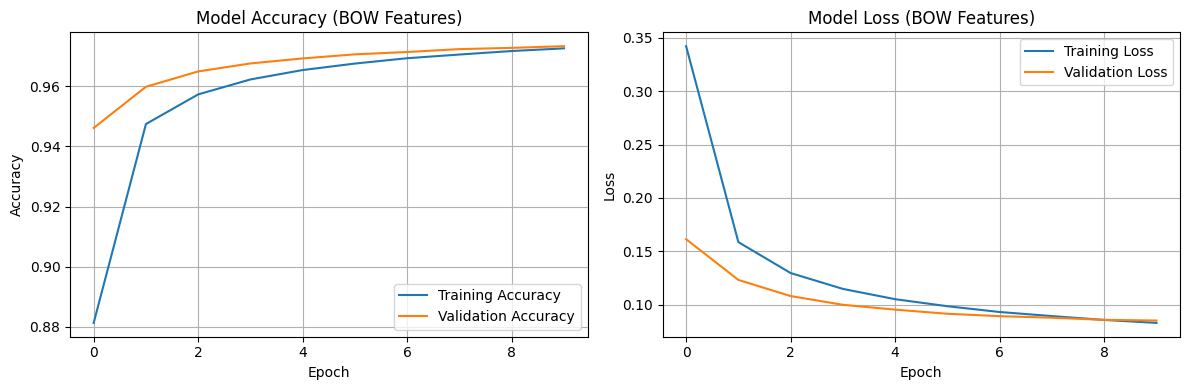


Final Training Accuracy: 0.9726
Final Validation Accuracy: 0.9734


In [10]:
# Plot results
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['train_accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy (BOW Features)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss (BOW Features)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('bilstm_bow_training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nFinal Training Accuracy: {history['train_accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {history['val_accuracy'][-1]:.4f}")

In [11]:
torch.save({
    'model_state_dict': model.state_dict(),
    'bow_vocab_size': bow_vocab_size,
    'num_classes': num_classes,
    'history': history
}, 'bilstm_bow_final_model.pth')

with open('bow_vectorizer.pickle', 'wb') as f:
    pickle.dump(bow_vectorizer, f)

print("Model and BOW vectorizer saved successfully!")
print("Files saved:")
print("  - bilstm_bow_final_model.pth")
print("  - best_bilstm_bow_model.pth")
print("  - bow_vectorizer.pickle")

Model and BOW vectorizer saved successfully!
Files saved:
  - bilstm_bow_final_model.pth
  - best_bilstm_bow_model.pth
  - bow_vectorizer.pickle
